**ARIMA** models are popular for forecasting in various fields, from business (sales) to finance (stock prices).

In this note book we will:
1. fit an ARIMA model
2. forecast from that model
3. compare different ARIMA models (tune hyperparameters) using RMSE of the forecasts

---

The acronym **ARIMA** stands for Auto-Regressive Integrated Moving Average. 

- **AR**: Lags of the **stationarized** series in the forecasting equation are called "autoregressive" terms
- **MA**: Lags of the **forecast errors (residuals)** are called "moving average" terms
- **I**: A time series which needs to be **differenced** to be made stationary is said to be an "integrated" version of a stationary series.
- Random-walk and random-trend models, autoregressive models, and exponential smoothing models are all special cases of ARIMA models.

A nonseasonal ARIMA model is classified as an **"ARIMA(p,d,q)"** model, where:

- **p**: The lag order (number of autoregressive terms), representing the number of lag observations incorporated in the model.
- **d**: Degree of differencing, denoting the number of times raw observations undergo differencing.
- **q**: Order of moving average (number of lagged forecast errors), indicating the size of the moving average window. 

The forecasting equation is constructed as follows.  First, let y denote the dth difference of Y, which means:

- If $d=0:  y_t  =  Y_t$

- If $d=1:  y_t  =  Y_t - Y_{t-1}$

- If $d=2:  y_t  =  (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2})  =  Y_t - 2Y_{t-1} + Y_{t-2}$

Note that the second difference of $Y$ (the $d=2$ case) is not the difference from 2 periods ago.  Rather, it is the first-difference-of-the-first difference, which is the discrete analog of a second derivative, i.e., the local acceleration of the series rather than its local trend.

In terms of y, the general forecasting equation is:

$$\hat{y}_t   =   μ + \phi_1 y_{t-1} +…+ \phi_p y_{t-p} - \theta_1 e_{t-1} -\dots-\theta_qe_{t-q}$$

Here the moving average parameters ($\theta$’s) are defined so that their signs are negative in the equation, following the convention introduced by Box and Jenkins.  Some authors and software (including the R programming language) define them so that they have plus signs instead.  When actual numbers are plugged into the equation, there is no ambiguity, but it’s important to know which convention your software uses when you are reading the output.  Often the parameters are denoted there by AR(1), AR(2), …, and MA(1), MA(2), … etc.

To identify the appropriate ARIMA model for $Y$, you begin by determining the order of differencing ($d$) needing to stationarize the series and remove the gross features of seasonality, perhaps in conjunction with a variance-stabilizing transformation such as logging or deflating. If you stop at this point and predict that the differenced series is constant, you have merely fitted a random walk or random trend model.  However, the stationarized series may still have autocorrelated errors, suggesting that some number of AR terms ($p \ge 1$) and/or some number MA terms ($q \ge 1$) are also needed in the forecasting equation.

### References
- https://people.duke.edu/~rnau/411arim.htm
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.simplefilter("ignore")

In [2]:
def parser(x):
    return '199' + x

data = pd.read_csv('shampoo.csv')
data['Month'] = data['Month'].apply(lambda x: parser(x))
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   36 non-null     datetime64[ns]
 1   Sales   36 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 708.0 bytes
None


,Month,Sales
0,1991-01-01,266.0
1,1991-02-01,145.9
2,1991-03-01,183.1
3,1991-04-01,119.3
4,1991-05-01,180.3


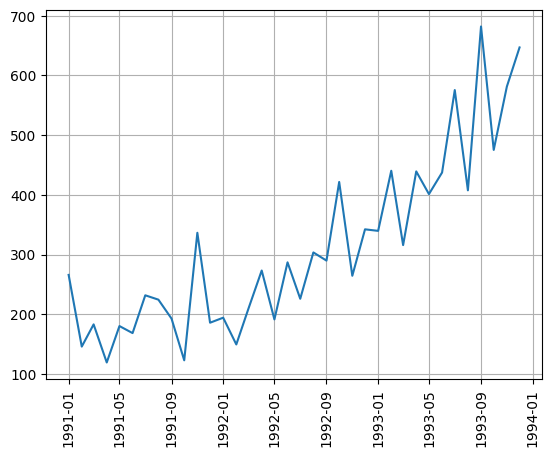

In [3]:
plt.plot(data['Month'], data['Sales'])
plt.xticks(rotation=90)
plt.grid();

## Inspect Autocorrelations

There is positive autocorrelation with the first 11-12 lags, and it is significant perhaps for the first 5 lags. So perhaps initiating the AR parameter of the model with a value of 5 could be a beneficial starting point.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

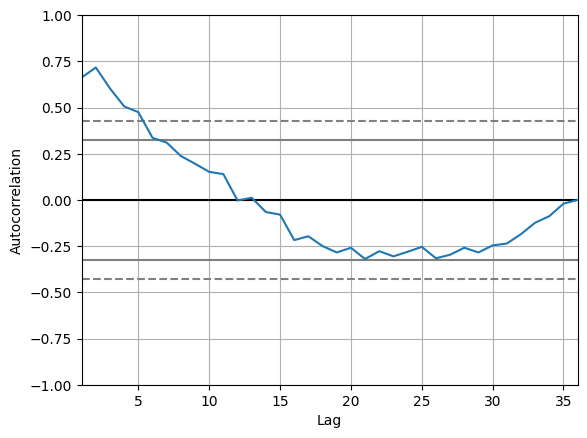

In [4]:
# Plot Autocorrelations
pd.plotting.autocorrelation_plot(data['Sales'])

In [5]:
# determine the order of differencing (d) needing to stationarize the series
df = data.copy()
# Shift the 'Sales' column by 1 position (effectively y(t-1))
df['Sales_shifted'] = df['Sales'].shift(1)
# Calculate the first order difference (y(t) - y(t-1))
df['First_Difference'] = df['Sales'] - df['Sales_shifted']
# Drop the first row (since there's no previous value for the first month)
df = df.iloc[1:]

## Inspect Differencing

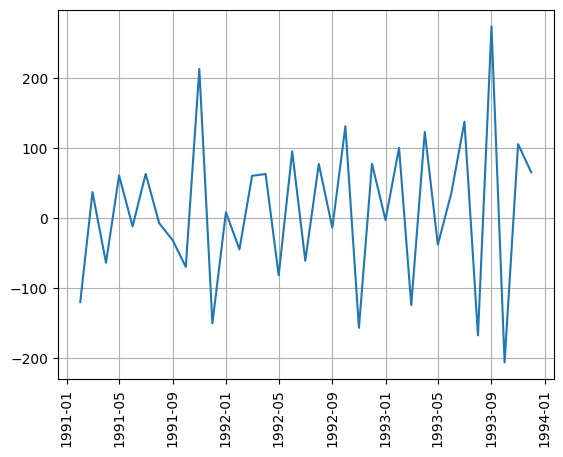

In [6]:
# plot the new time series; notice that it is more close to stationarity than the original
plt.plot(df['Month'], df['First_Difference'])
plt.xticks(rotation=90)
plt.grid();

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

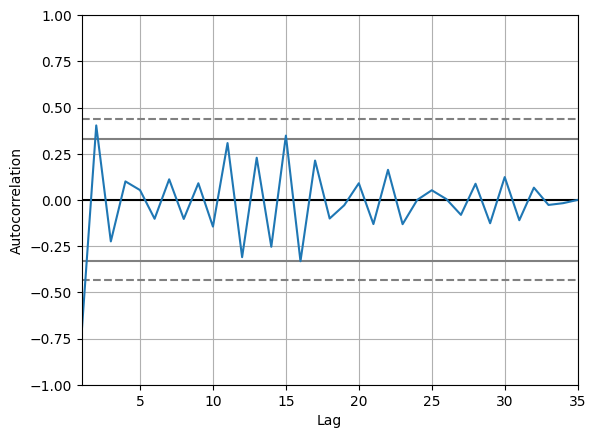

In [7]:
# Plot Autocorrelations
pd.plotting.autocorrelation_plot(df['First_Difference'])

## Fit ARIMA(5, 1, 0) Model

- 5 lags for autoregression (AR)
- 1st order differencing (I)
- No moving average term (MA) 

In [8]:
# fit model
p, d, q = 5, 1, 0
df = data.copy().set_index('Month')
model = ARIMA(df, order=(p, d, q))
model_fit = model.fit()

In [9]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Fri, 05 Apr 2024   AIC                            408.969
Time:                        15:02:39   BIC                            418.301
Sample:                    01-01-1991   HQIC                           412.191
                         - 12-01-1993                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

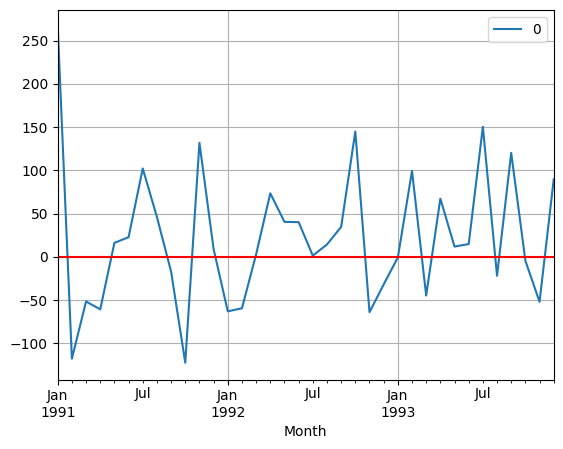

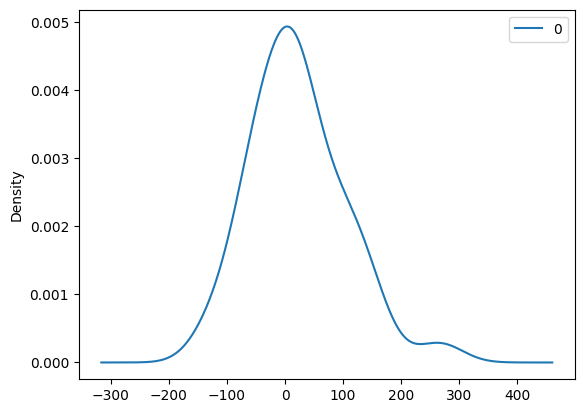

In [10]:
# inspect the residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.axhline(0, color='red')
plt.grid()

residuals.plot(kind='kde');


In [11]:
residuals.describe()

,0
count,36.000000
mean,21.936144
std,80.774430
min,-122.292030
25%,-35.040859
50%,13.147219
75%,68.848286
max,266.000000


## Rolling Forecast
Here we predict one step ahead (using  the `forecast()` function), and the model is retrained as new data becomes available, allowing more accurate predictions. In the code below, we manually keep track of all observations in a list called `history` that is seeded with the training data and to which new observations are appended each iteration.

By default, the `forecast()` function makes a single step out-of-sample forecast. As such, we can call it directly and make our forecast. The output is an array containing the forecast value, the standard error of the forecast, and the confidence interval information. Now, we are only interested in the first element of this forecast

In [12]:
X = df['Sales'].values
n_train = int(len(X) * 0.66)
X_train, X_test = X[:n_train], X[n_train+1:]
predictions = []
history = list(X_train)

for t in range(len(X_test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = X_test[t]
    history.append(obs)
    print(f'Predicted={yhat:.3f}, Expected={obs}')

# Evaluate MSE, RMSE
mse = np.mean((X_test - np.array(predictions))**2)
rmse = np.sqrt(mse)
print(f'RMSE={rmse:.3f}')
    

Predicted=343.272, Expected=339.7
Predicted=292.916, Expected=440.4
Predicted=376.290, Expected=315.9
Predicted=368.590, Expected=439.3
Predicted=331.151, Expected=401.3
Predicted=422.833, Expected=437.4
Predicted=406.623, Expected=575.5
Predicted=437.237, Expected=407.6
Predicted=527.906, Expected=682.0
Predicted=493.363, Expected=475.3
Predicted=625.332, Expected=581.3
Predicted=579.160, Expected=646.9
RMSE=89.229


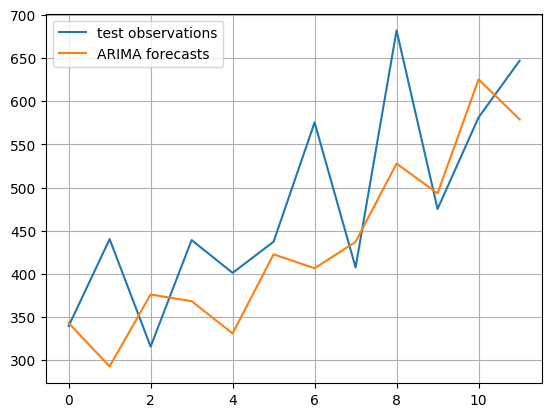

In [13]:
plt.plot(X_test, label='test observations')
plt.plot(predictions, label='ARIMA forecasts')
plt.legend()
plt.grid();

## Grid Over ARIMA hyperparameters / ARIMA Model Comparison

In [14]:
def evaluate_arima_model(df, arima_order, return_full_results=False):
    X = df['Sales'].values
    n_train = int(len(X) * 0.66)
    X_train, X_test = X[:n_train], X[n_train+1:]
    predictions = []
    history = list(X_train)
    
    for t in range(len(X_test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = X_test[t]
        history.append(obs)
        # print(f'Predicted={yhat:.3f}, Expected={obs}')
    
    # Evaluate MSE
    mse = np.mean((X_test - np.array(predictions))**2)
    rmse = np.sqrt(mse)
    if return_full_results:
        return rmse, X_test, predictions, model_fit
    else:
        return rmse


def evaluate_models(df, p_values, d_values, q_values):
    rmse_scores = {}
    for p in p_values:
        for d in d_values:
            for q in q_values:
                arima_order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(df, arima_order)
                    rmse_scores[arima_order] = rmse
                    print(arima_order, f'RMSE={rmse}')
                except:
                    continue
    return rmse_scores

p_values = [0, 1, 2, 3, 4, 5, 6]
d_values = [0, 1, 2]
q_values = [0, 1, 2]

rmse_scores = evaluate_models(df, p_values, d_values, q_values)

min_rmse = min(rmse_scores.values())
best_parm_combo = [key for key, value in rmse_scores.items() if value == min_rmse][0]
print(f'\nSmallest RMSE is {np.round(min_rmse, 3)} for ARIMA(p, d, q)={best_parm_combo}')

(0, 0, 0) RMSE=238.25699413783903
(0, 0, 1) RMSE=202.14897458918315
(0, 0, 2) RMSE=165.576353485154
(0, 1, 0) RMSE=138.47147118931514
(0, 1, 1) RMSE=109.1666532273052
(0, 1, 2) RMSE=79.4843278553725
(0, 2, 0) RMSE=262.81547867911644
(0, 2, 1) RMSE=139.5574410861605
(0, 2, 2) RMSE=78.7366845410585
(1, 0, 0) RMSE=158.57971875081702
(1, 0, 1) RMSE=117.49627039049125
(1, 0, 2) RMSE=86.87709325249351
(1, 1, 0) RMSE=97.67075414654228
(1, 1, 1) RMSE=93.6612943496255
(1, 1, 2) RMSE=85.50188343028233
(1, 2, 0) RMSE=156.45871177970494
(1, 2, 1) RMSE=95.38735754784868
(1, 2, 2) RMSE=69.28423555414564
(2, 0, 0) RMSE=110.77419391126489
(2, 0, 1) RMSE=109.21770912685045
(2, 0, 2) RMSE=104.43769098421211
(2, 1, 0) RMSE=88.51156097437497
(2, 1, 1) RMSE=90.90108141521273
(2, 1, 2) RMSE=93.4260420073845
(2, 2, 0) RMSE=94.73488937616524
(2, 2, 1) RMSE=77.85163922072601
(2, 2, 2) RMSE=83.49000603748594
(3, 0, 0) RMSE=102.99878294665156
(3, 0, 1) RMSE=104.2952842388222
(3, 0, 2) RMSE=102.35063221680674
(3,

In [15]:
results = pd.DataFrame({'params': rmse_scores.keys(), 'rmse': rmse_scores.values()})
results.sort_values(by='rmse').head()

,params,rmse
17,"(1, 2, 2)",69.284236
43,"(4, 2, 1)",75.675749
52,"(5, 2, 1)",76.427840
25,"(2, 2, 1)",77.851639
44,"(4, 2, 2)",78.140320


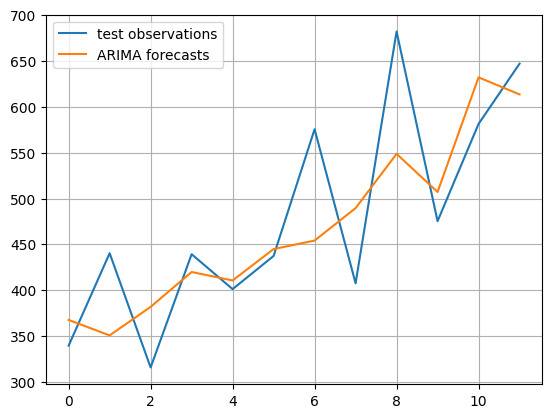

In [16]:
# Let's look at our winner!
# fit model
arima_order = (1, 2, 2)
rmse, X_test, predictions, model_fit = evaluate_arima_model(df, arima_order, return_full_results=True)
plt.plot(X_test, label='test observations')
plt.plot(predictions, label='ARIMA forecasts')
plt.legend()
plt.grid();